In [22]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load iris dataset
iris = datasets.load_iris()

# since this is a bunch, create a dataframe

iris_df=pd.DataFrame(iris.data)
iris_df['class']=iris.target
iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # remove any empty lines
iris = iris_df.sample(frac=1).reset_index(drop=True)

print(iris)


     sepal_len  sepal_wid  petal_len  petal_wid  class
0          5.4        3.4        1.5        0.4      0
1          6.3        2.8        5.1        1.5      2
2          6.9        3.1        5.4        2.1      2
3          5.4        3.0        4.5        1.5      1
4          5.6        3.0        4.5        1.5      1
..         ...        ...        ...        ...    ...
145        6.5        3.2        5.1        2.0      2
146        5.8        2.8        5.1        2.4      2
147        4.4        3.2        1.3        0.2      0
148        7.2        3.2        6.0        1.8      2
149        6.9        3.1        4.9        1.5      1

[150 rows x 5 columns]


In [23]:
class Model:
    numberOfClasses = 0
    numberOfFeatures = 0
    numberOfHiddenLayerUnits = 0
    X = None
    Y = None
    X_forTraining = None
    X_forTesting = None
    Y_forTraining = None
    Y_forTesting = None
    Y_train_encoded = None
    Y_test_encoded = None
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    splitRange = 75
    
    # One-hot encode the labels for categorical cross-entropy
    def one_hot_encode(self, labels, num_classes):
        return np.eye(num_classes)[labels]
        
    def prepareInputData(self, inputDataFrame: pd.DataFrame, numberOfClasses: int, numberOfFeatures: int, numberOfHiddenLayerUnits: int, splitRange):
        self.numberOfClasses = numberOfClasses
        self.numberOfFeatures = numberOfFeatures
        self.numberOfHiddenLayerUnits = numberOfHiddenLayerUnits

        print(self.numberOfHiddenLayerUnits)
        self.splitRange = splitRange
        self.X = inputDataFrame.iloc[:, 0:numberOfFeatures]
        self.Y = inputDataFrame.iloc[:, -1]
        
        
        self.X_forTraining, self.X_forTesting = self.X.iloc[:self.splitRange], self.X.iloc[self.splitRange:]
        self.Y_forTraining, self.Y_forTesting = self.Y.iloc[:self.splitRange], self.Y.iloc[self.splitRange:]

        self.Y_train_encoded = self.one_hot_encode(self.Y_forTraining, self.numberOfClasses)
        self.Y_test_encoded = self.one_hot_encode(self.Y_forTesting, self.numberOfClasses)

        # print(self.Y_test_encoded.shape)
        # print(self.Y_test_encoded)
        # print(self.Y_forTesting.shape)
        # print(self.Y_forTesting)
    
    def initializeStartParameters(self):
        np.random.seed(42)
        self.W1 = np.random.randn(self.numberOfFeatures, self.numberOfHiddenLayerUnits)

        # print(self.W1)
        self.b1 = np.zeros((1, self.numberOfHiddenLayerUnits))
        self.W2 = np.random.randn(self.numberOfHiddenLayerUnits, self.numberOfClasses)
        self.b2 = np.zeros((1, self.numberOfClasses))
    
    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self,Z):
        return Z > 0

    def softmax(self,Z):
        Z = Z.to_numpy()
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def compute_loss(self,Y, Y_hat):
        m = Y.shape[0]
        return -np.sum(Y * np.log(Y_hat + 1e-9)) / m
    
    def forwardPropagation(self, X):
        Z1 = X.dot(self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.W2) + self.b2
        A2 = self.softmax(Z2)
        return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    def backwardPropagation(self, X, Y, cache):
        m = X.shape[0]

        dZ2 = cache["A2"] - Y
        dW2 = (1 / m) * np.dot(cache["A1"].T, dZ2)
        # dW2 =  np.dot(cache["A1"].T, dZ2)  / m
        
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * self.relu_derivative(cache["Z1"])

        dW1 = (1 / m) * np.dot(X.T, dZ1)
        
        db1 = (1 / m) * np.sum(dZ1.to_numpy(), axis=0, keepdims=True)

        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def updateParameters(self, grads, learningRate):
        self.W1 -= learningRate * grads["dW1"]
        self.b1 -= learningRate * grads["db1"]
        self.W2 -= learningRate * grads["dW2"]
        self.b2 -= learningRate * grads["db2"]

    def evaluate( self):
        # Perform forward propagation to get predictions
        
        cache = self.forwardPropagation(self.X_forTesting)
        
        predictions = np.argmax(cache["A2"], axis=1)  # Choose the class with the highest probability
    
        # Calculate accuracy
        accuracy = np.mean(predictions == self.Y_forTesting) * 100  # Compare predictions to true labels and compute percentage
        
        return accuracy
        
    def evaluateFullDataset( self):
        # Perform forward propagation to get predictions
        cache = self.forwardPropagation(self.X)
        predictions = np.argmax(cache["A2"], axis=1)  # Choose the class with the highest probability

        # print(predictions.shape)
        # print(predictions)
        # print(self.Y.shape)
        # print(self.Y)

        
        # Calculate accuracy
        accuracy = np.mean(predictions == self.Y) * 100  # Compare predictions to true labels and compute percentage
        return accuracy

In [43]:
Iris = Model()
Iris.prepareInputData(iris, 3, 4, 15, 120)

15


In [46]:
import json
epochs=2000
learning_rate=0.12149999999999998

Iris.initializeStartParameters()

for epoch in range(epochs):
    # Forward pass on training data
    train_cache = Iris.forwardPropagation(Iris.X_forTraining)
    
    loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])

    
    # Backward pass (compute gradients)
    grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
    
    # Update parameters
    Iris.updateParameters(grads, learning_rate)
    
    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        test_cache = Iris.forwardPropagation(Iris.X_forTesting)
        test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
        
        print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")

accuracy = Iris.evaluate()


    
print(f"Accuracy: {accuracy :.2f}%")

Epoch 0, Training loss: 6.7648, Test loss: 8.1431
Epoch 100, Training loss: 0.2976, Test loss: 0.3275
Epoch 200, Training loss: 0.2273, Test loss: 0.2653
Epoch 300, Training loss: 0.1716, Test loss: 0.1888
Epoch 400, Training loss: 0.0910, Test loss: 0.1197
Epoch 500, Training loss: 0.0744, Test loss: 0.0813
Epoch 600, Training loss: 0.0883, Test loss: 0.1471
Epoch 700, Training loss: 0.0661, Test loss: 0.0566
Epoch 800, Training loss: 0.0622, Test loss: 0.0598
Epoch 900, Training loss: 0.0594, Test loss: 0.0558
Epoch 1000, Training loss: 0.0573, Test loss: 0.0529
Epoch 1100, Training loss: 0.0557, Test loss: 0.0530
Epoch 1200, Training loss: 0.0543, Test loss: 0.0505
Epoch 1300, Training loss: 0.0531, Test loss: 0.0496
Epoch 1400, Training loss: 0.0521, Test loss: 0.0482
Epoch 1500, Training loss: 0.0510, Test loss: 0.0469
Epoch 1600, Training loss: 0.0502, Test loss: 0.0491
Epoch 1700, Training loss: 0.0494, Test loss: 0.0515
Epoch 1800, Training loss: 0.0487, Test loss: 0.0451
Epoch

In [47]:
accuracy = Iris.evaluateFullDataset()
print(f"Layer size : {Iris.b1.shape}")
print(f"Accuracy: {accuracy :.2f}%")
print()
print("W1:", json.dumps(Iris.W1.tolist()))
print()
print("W2:", json.dumps(Iris.W2.tolist()))
print()
print("b1:", json.dumps(Iris.b1.tolist()))
print()
print("b2:", json.dumps(Iris.b2.tolist()))




Layer size : (1, 15)
Accuracy: 99.33%

W1: [[0.4967141530112327, -0.33847245047896035, 0.05844000298151869, 0.8168682000651932, -0.23415337472333597, 0.5179338271282651, 1.4698691619123851, 0.5712502235020903, -0.4694743859349521, 0.0507074440104997, -0.7618384655432767, -0.46572975357025687, 0.8948089072662644, -1.913280244657798, -1.7249178325130328], [-0.5622875292409727, -1.231513522059426, -0.036203749665170454, -1.3272995263574823, -1.4123037013352915, 2.822742456094777, -0.31747604015649367, -0.06687197238167811, -1.4247481862134568, -0.7843521387307402, -0.19207034576477205, -1.1509935774223028, 0.8165315052678815, -0.600638689918805, -0.2916937497932768], [-0.6017066122293969, 2.4408099965047327, -0.3780625478300726, -1.384406580488608, 0.822544912103189, -1.943466047364582, -1.3256568349393296, -2.0130650348347854, -1.3281860488984305, -0.10914315541329599, 0.8083457942941001, 0.1713682811899705, -0.5684882098189431, -0.3011036955892888, -1.4785219903674274], [-0.719844208394

In [50]:
def export_network_params(W1, b1, W2, b2, filename=None):
    network_params = {
        "W1": W1.tolist(),
        "b1": b1.tolist(),
        "W2": W2.tolist(),
        "b2": b2.tolist()
    }
    if filename:
        with open(filename, 'w') as file:
            json.dump(network_params, file)
        return ""
    else:
        network_params_json = json.dumps(network_params)
        # Now network_params_json contains the JSON representation of network_params
        return network_params_json

In [51]:
export_network_params(
    Iris.W1,
    Iris.b1,
    Iris.W2,
    Iris.b2,
    "99.33_on_15_layers.json"
)

''

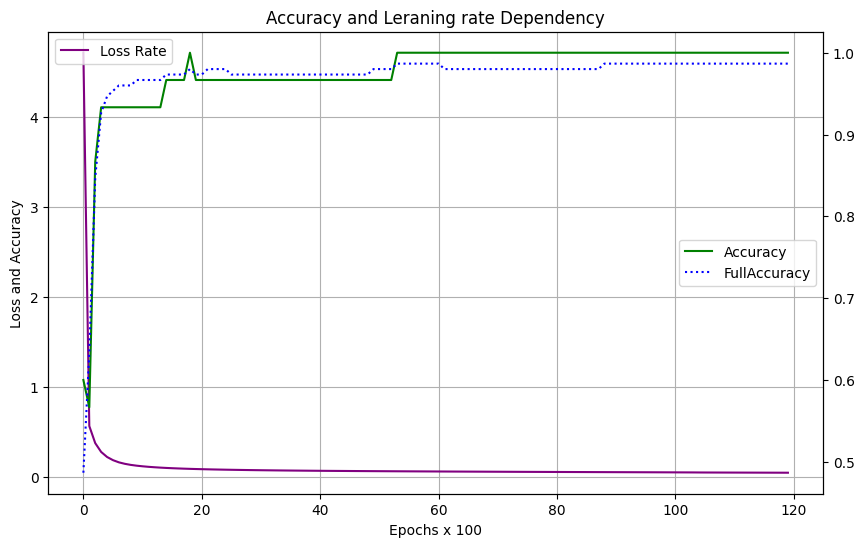

In [35]:
epochs=12000
learning_rate=0.0115


lossValues = []
# LrValues = [] 
accuracyValues = []
fullAccuracyValues = []

Iris.initializeStartParameters()
for epoch in range(epochs):
    # Forward pass on training data
    train_cache = Iris.forwardPropagation(Iris.X_forTraining)
    
    loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])

    
    # Backward pass (compute gradients)
    grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
    
    # Update parameters
    Iris.updateParameters(grads, learning_rate)
    
    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        test_cache = Iris.forwardPropagation(Iris.X_forTesting)
        test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
        
        # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")

        lossValues.append(test_loss)

        accuracy = Iris.evaluate()
        fullAccuracy = Iris.evaluateFullDataset()
        accuracyValues.append(accuracy/100)
        fullAccuracyValues.append(fullAccuracy/100)

# Plotting the list
plt.figure(figsize=(10, 6))
plt.title('Accuracy and Leraning rate Dependency')
plt.xlabel('Epochs x 100')
plt.ylabel('Loss and Accuracy')
plt.grid(True)

plt.plot(lossValues,  linestyle='-', color='purple', label='Loss Rate')
plt.legend(loc='upper left')
# Create a second y-axis for the second list

ax2 = plt.twinx()
ax2.plot(accuracyValues,  linestyle='-', color='green', label='Accuracy')
# Adding legends for both plots
ax2.plot(fullAccuracyValues,  linestyle=':', color='blue', label='FullAccuracy')
ax2.legend(loc='center right')

# Create a second y-axis for the second list
# ax2 = plt.twinx()
# ax2.plot(LrValues, marker='o', linestyle='--', color='red', label='Learning Rate')
# ax2.set_ylabel('Learning Rate', color='red')

plt.show()
accuracyValues = []
fullAccuracyValues = []
lossValues = []

Learning Rate : 0.0115
Layer size : (1, 15)
Accuracy : 96.66666666666667
Accuracy Full Dataset : 97.33333333333334
Learning Rate : 0.0215
Layer size : (1, 15)
Accuracy : 96.66666666666667
Accuracy Full Dataset : 97.33333333333334
Learning Rate : 0.0315
Layer size : (1, 15)
Accuracy : 96.66666666666667
Accuracy Full Dataset : 98.0
Learning Rate : 0.0415
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 98.0
Learning Rate : 0.051500000000000004
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 98.0
Learning Rate : 0.061500000000000006
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 98.0
Learning Rate : 0.07150000000000001
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 97.33333333333334
Learning Rate : 0.0815
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 97.33333333333334
Learning Rate : 0.0915
Layer size : (1, 15)
Accuracy : 100.0
Accuracy Full Dataset : 97.33333333333334
Learning Rate : 0.10149999999999999
Layer size :

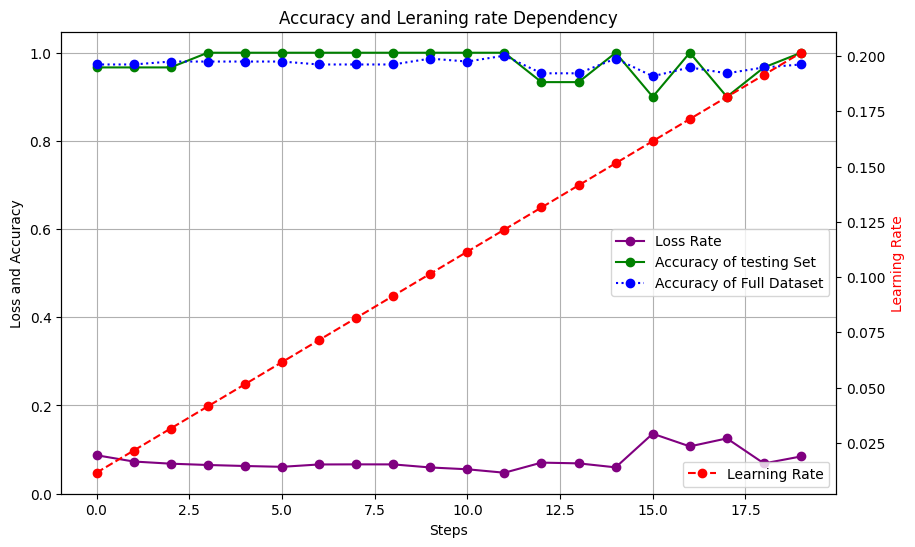

In [36]:
epochs=2000
tests = 20
learning_rate=0.0115


lossValues = []
LrValues = []
accuracyValues = []
fullAccuracyValues = []

for test in range(tests):
    Iris.initializeStartParameters()
    for epoch in range(epochs):
        # Forward pass on training data
        train_cache = Iris.forwardPropagation(Iris.X_forTraining)
        
        loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])
    
        
        # Backward pass (compute gradients)
        grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
        
        # Update parameters
        Iris.updateParameters(grads, learning_rate)
        
        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            test_cache = Iris.forwardPropagation(Iris.X_forTesting)
            test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
            
            # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")
    LrValues.append(learning_rate)
    
    lossValues.append(loss)
    
    accuracy = Iris.evaluate()
    fullAccuracy = Iris.evaluateFullDataset()
    accuracyValues.append(accuracy/100)
    fullAccuracyValues.append(fullAccuracy/100)

    print(f"Learning Rate : {learning_rate}")
    print(f"Layer size : {Iris.b1.shape}")
    print(f"Accuracy : {accuracy}")
    print(f"Accuracy Full Dataset : {fullAccuracy}")
    
    learning_rate += 0.01
    # print(f"Accuracy: {accuracy :.2f}%")


# Plotting the list
plt.figure(figsize=(10, 6))
plt.xlabel('Steps')
plt.title('Accuracy and Leraning rate Dependency')
plt.ylabel('Loss and Accuracy')
plt.grid(True)

plt.plot(lossValues, marker='o', linestyle='-', color='purple', label='Loss Rate')
plt.plot(accuracyValues, marker='o', linestyle='-', color='green', label='Accuracy of testing Set')
plt.plot(fullAccuracyValues, marker='o', linestyle=':', color='blue', label='Accuracy of Full Dataset')

plt.legend(loc='center right')
# plt.legend(['Accuracy'], loc='upper left')

# Create a second y-axis for the second list
ax2 = plt.twinx()
ax2.plot(LrValues, marker='o', linestyle='--', color='red', label='Learning Rate')
ax2.set_ylabel('Learning Rate', color='red')

# Adding legends for both plots
ax2.legend( loc='lower right')

plt.show()
accuracyValues = []
fullAccuracyValues = []
lossValues = []

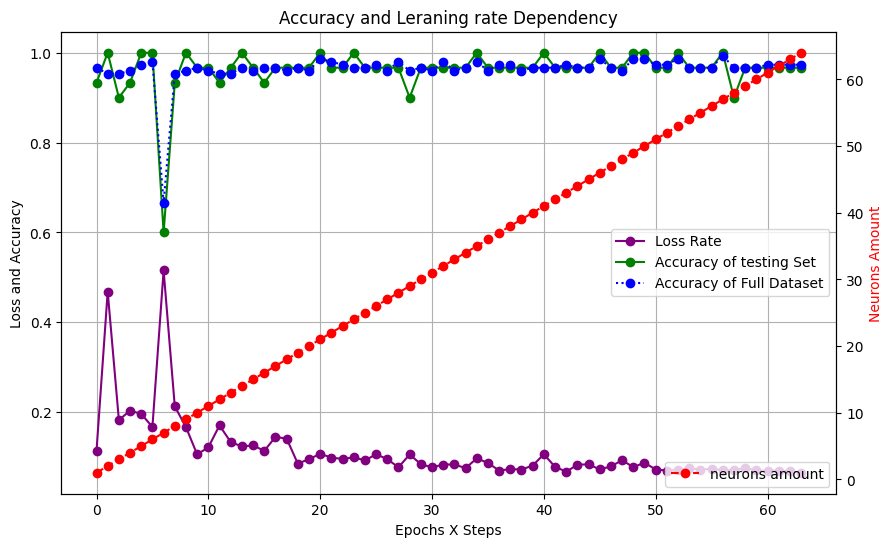

In [29]:
epochs=1000
tests = 64
learning_rate=0.0125


lossValues = []
neurons = 1
neurons_array = []
accuracyValues = []
fullAccuracyValues = []


for test in range(tests):
    
    Iris.initializeStartParameters()
    Iris.numberOfHiddenLayerUnits = neurons
    
    for epoch in range(epochs):
        # Forward pass on training data
        train_cache = Iris.forwardPropagation(Iris.X_forTraining)
        
        loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])
    
        
        # Backward pass (compute gradients)
        grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
        
        # Update parameters
        Iris.updateParameters(grads, learning_rate)
        
        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            test_cache = Iris.forwardPropagation(Iris.X_forTesting)
            test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
            
            # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")
    neurons_array.append(neurons)
    neurons += 1

    
    lossValues.append(loss)
    
    accuracy = Iris.evaluate()
    fullAccuracy = Iris.evaluateFullDataset()
    accuracyValues.append(accuracy/100)
    fullAccuracyValues.append(fullAccuracy/100)
    
    # print(f"Accuracy: {accuracy :.2f}%")
Iris.numberOfHiddenLayerUnits = 1
# x = range(1, neurons_array)
# Plotting the list
plt.figure(figsize=(10, 6))
plt.xlabel('Epochs X Steps')
plt.title('Accuracy and Leraning rate Dependency')
plt.ylabel('Loss and Accuracy')
plt.grid(True)

plt.plot(lossValues, marker='o', linestyle='-', color='purple', label='Loss Rate')
plt.plot(accuracyValues, marker='o', linestyle='-', color='green', label='Accuracy of testing Set')
plt.plot(fullAccuracyValues, marker='o', linestyle=':', color='blue', label='Accuracy of Full Dataset')

plt.legend()
# plt.legend(['Accuracy'], loc='upper left')

# Create a second y-axis for the second list
ax2 = plt.twinx()
ax2.plot(neurons_array, marker='o', linestyle='--', color='red', label='neurons amount')
ax2.set_ylabel('Neurons Amount', color='red')

# Adding legends for both plots
ax2.legend( loc='lower right')

plt.show()
accuracyValues = []
fullAccuracyValues = []
lossValues = []